# Own CNN Approach

Notes regarding my approach:

#### 1st run
* Inital setup see [here](../data/outputs/1_stfn-cnn-1.txt)
* Performance after 1 epoch
  * 79s 2s/step - loss: 2.3030 - accuracy: 0.1561 - val_loss: 1.5133 - val_accuracy: 0.5826
  * 63/63 - 18s - loss: 27.4566 - accuracy: 0.6021 - 18s/epoch - 279ms/step

#### 2nd run:
* added Batch Normalization - helps stabilize training and can lead to faster convergence.
* see [here](../data/outputs/1_stfn-cnn-2.txt)
* Performance after 1 epoch
  * 89s 2s/step - loss: 2.1006 - accuracy: 0.2388 - val_loss: 2.4401 - val_accuracy: 0.0514
  * 63/63 - 24s - loss: 110.5687 - accuracy: 0.0649 - 24s/epoch - 384ms/step
* Performance after 2 epochs
  * .
  * 63/63 - 22s - loss: 117.1542 - accuracy: 0.0534 - 22s/epoch - 354ms/step
* **Note:** Accuracy is decreasing, so I commented out the Batch Normalization again.

#### 3rd run:
* added 3rd conv. block
* see [here](../data/outputs/1_stfn-cnn-3.txt)
* Perfomance after 10 epochs
  * 63/63 - 26s - loss: 532.7207 - accuracy: 0.3450 - 26s/epoch - 410ms/step

#### 4th run:
* added residual block
* added 4th conv block
* removed flatten / added maxpooling
* see [here](../data/outputs/1_stfn-cnn-4.txt)
* Perfomance: bad

## Imports and inital setup

In [48]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from keras.layers import Conv2D, MaxPool2D, Input, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout
import tensorflow as tf

import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh

SEED = 42
NUM_EPOCHS = 10

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx"
BALANCE_LABEL="dx"
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

### Loading (augmented) metadata as test, train, validation from files

In [49]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
3263,HAM_0003046,aug_l7sWq9ISIC_0034119.jpg,bcc,histo,70.0,male,face,vidir_modern,skin_cancer,./../data/jpgs/aug_l7sWq9ISIC_0034119.jpg
2664,HAM_0004027,aug_71CqX7ISIC_0030403.jpg,bcc,histo,65.0,female,back,rosendahl,skin_cancer,./../data/jpgs/aug_71CqX7ISIC_0030403.jpg
11840,HAM_0000202,aug_B7nhJmISIC_0027219.jpg,bkl,histo,50.0,male,face,rosendahl,not_skin_cancer,./../data/jpgs/aug_B7nhJmISIC_0027219.jpg
12418,HAM_0007410,aug_2vSxL7ISIC_0031457.jpg,df,histo,65.0,male,foot,rosendahl,not_skin_cancer,./../data/jpgs/aug_2vSxL7ISIC_0031457.jpg
1145,HAM_0007298,ISIC_0028345.jpg,nv,follow_up,45.0,male,trunk,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0028345.jpg
10450,HAM_0004332,ISIC_0033785.jpg,bkl,histo,55.0,male,trunk,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0033785.jpg
12888,HAM_0004103,aug_7ehoqBISIC_0028880.jpg,df,histo,55.0,male,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_7ehoqBISIC_0028880.jpg
12920,HAM_0007225,aug_gqssrvISIC_0032247.jpg,df,histo,75.0,male,lower extremity,vienna_dias,not_skin_cancer,./../data/jpgs/aug_gqssrvISIC_0032247.jpg
5197,HAM_0005274,aug_QVKzKLISIC_0033141.jpg,mel,histo,55.0,male,upper extremity,vidir_modern,skin_cancer,./../data/jpgs/aug_QVKzKLISIC_0033141.jpg
7791,HAM_0006483,aug_fb5QRxISIC_0032371.jpg,akiec,histo,75.0,male,upper extremity,rosendahl,skin_cancer,./../data/jpgs/aug_fb5QRxISIC_0032371.jpg


## Setting up the image data generator for training and validation

In [50]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0 #see above
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
)

Found 2003 validated image filenames belonging to 7 classes.
Found 14006 validated image filenames belonging to 7 classes.


# Adding an neural network model to test the data

## Own Model Architecture

In [51]:
def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'valid'):
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x

In [52]:
def residual_block(prev_layer, nbr_kernels, filter_size, padding='same'):
    residual = prev_layer

    # First convolutional layer
    x = tf.keras.layers.Conv2D(nbr_kernels, filter_size, padding='same')(prev_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Second convolutional layer
    x = tf.keras.layers.Conv2D(nbr_kernels, filter_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Ensure the residual is of the same shape as x
    # If not, apply a 1x1 convolution to it
    if residual.shape[-1] != nbr_kernels:
        residual = tf.keras.layers.Conv2D(nbr_kernels, (1, 1), padding='same')(residual)

    # Add the residual connection
    x = tf.keras.layers.add([x, residual])

    # Pooling layer
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)

    return x

In [59]:
# Input layer
input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Convolutional block 1
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 2
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 3 
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 4
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Convolutional block 5 // new
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

# Residual block added X addded new wit 512
x = residual_block(x, 512, (3, 3))

# Residual block 
x = residual_block(x, 256, (3, 3))

# Global average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Flatten the output of the convolutional layers // removed here
# x = tf.keras.layers.Flatten()(x)

# Additional Dense (fully connected) layers / new
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Dropout layer
x = tf.keras.layers.Dropout(0.5)(x) 

# Additional Dense (fully connected) as is
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Dropout layer
x = tf.keras.layers.Dropout(0.2)(x) 

# Output layer
output_layer = tf.keras.layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Stfn CNN self build with 4convBlock 2resBlock GaPooling 2Dropout')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "Stfn CNN self build with 4convBlock 2resBlock GaPooling 2Dropout"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 297, 297, 32)         896       ['input_6[0][0]']             
                                                                                                  
 max_pooling2d_26 (MaxPooli  (None, 148, 148, 32)         0         ['conv2d_34[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_35 (Conv2D)          (None,

## Model Training

In [54]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=None,                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/10
438/438 [==============================] - 1258s 3s/step - loss: 1.9307 - accuracy: 0.1800 - val_loss: 1.1191 - val_accuracy: 0.6695
Epoch 2/10
438/438 [==============================] - 1377s 3s/step - loss: 1.8381 - accuracy: 0.2180 - val_loss: 1.2035 - val_accuracy: 0.5377
Epoch 3/10
438/438 [==============================] - 1423s 3s/step - loss: 1.7923 - accuracy: 0.2360 - val_loss: 1.8029 - val_accuracy: 0.3170
Epoch 4/10
438/438 [==============================] - 1233s 3s/step - loss: 1.7221 - accuracy: 0.2797 - val_loss: 1.8137 - val_accuracy: 0.1593
Epoch 5/10
438/438 [==============================] - 1529s 3s/step - loss: 1.6347 - accuracy: 0.3469 - val_loss: 1.6526 - val_accuracy: 0.2097
Epoch 6/10
438/438 [==============================] - 1182s 3s/step - loss: 1.4995 - accuracy: 0.3926 - val_loss: 1.8659 - val_accuracy: 0.3834
Epoch 7/10
438/438 [==============================] - 1084s 2s/step - loss: 1.4127 - accuracy: 0.4280 - val_loss: 1.5636 - val_accuracy:

## Plotting accuracy and loss of train and validation set

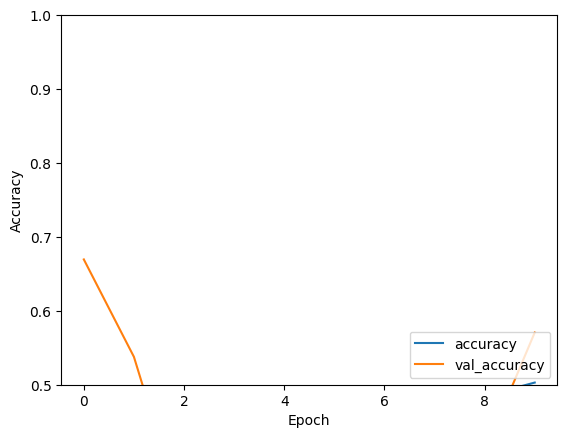

In [55]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

In [56]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

63/63 - 37s - loss: 368.5890 - accuracy: 0.6580 - 37s/epoch - 586ms/step


## Saving the model

In [57]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Continue training

In [58]:
# Continue training for another 10 epochs
additional_epochs = 10
continue_training = False

if continue_training:
    history_continued = model.fit(
        train_data_generator,
        steps_per_epoch=None,
        epochs=NUM_EPOCHS + additional_epochs,
        initial_epoch=NUM_EPOCHS,  # start from the epoch after your last training session
        validation_data=validation_generator)


Epoch 11/20
186/438 [===========>..................] - ETA: 9:57 - loss: 1.2416 - accuracy: 0.5082

KeyboardInterrupt: 

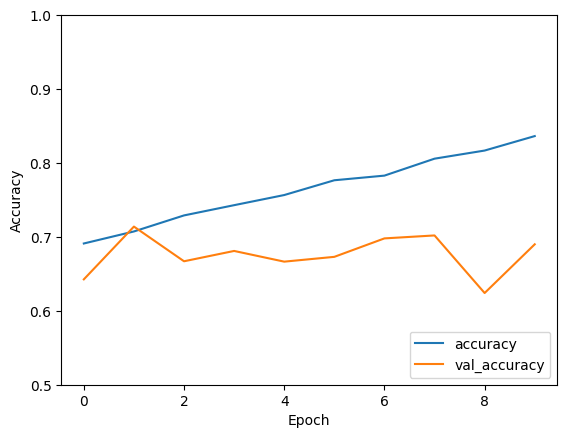

In [ ]:
if continue_training:
    mh.model_plot_accuracy(history_continued)

In [ ]:
if continue_training:
    mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

63/63 - 29s - loss: 1706.8292 - accuracy: 0.6695 - 29s/epoch - 466ms/step


In [ ]:
if continue_training:
    from datetime import datetime
    timestamp = datetime.now()
    model_path = f"../models/model_{timestamp}.h5"
    model.save(model_path)